In [1]:
import torch
import gpytorch
import GPy
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK

from mpl_toolkits.mplot3d import Axes3D  


import scipy
from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [2]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
#     import pdb; pdb.set_trace()
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
#     import pdb; pdb.set_trace()
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [3]:
def plot_trajectories_both(Xts,t , Xts_, t_, name=None):

    fn = 14
    fig = plt.figure(figsize=(15,10))
    
    n = Xts.shape[0]
    
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_xlabel("$t$", fontsize=fn)
    ax.set_ylabel("$x(t)$", fontsize=fn)
    ax.set_zlabel("$y(t)$", fontsize=fn)
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        ti, xi = t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy()
        ax.plot(ti, xi[:,0], xi[:,1],  'b', alpha=0.3,  label=label)
    
    
    ax.legend(fontsize=fn)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    tt = ax.get_xticks()
    ax.set_xlabel("$t$", fontsize=fn)
    ax.set_ylabel("$x(t)$", fontsize=fn)
    ax.set_zlabel("$y(t)$", fontsize=fn)
    
    n = Xts_.shape[0]
    
    ax.set_xticks(tt.flatten() )
    ax.set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        ti, xi = t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy()
        ax.plot(ti, xi[:,0], xi[:,1], 'r', alpha=0.3, label=label)

    ax.legend(fontsize=fn)
    
    if name is not None:
        plot.savefig(name)
    plt.show() 

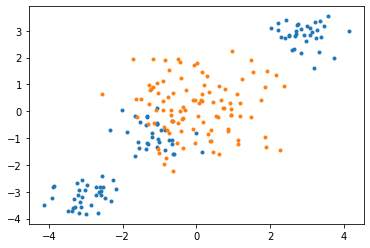

In [4]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
n = 102
n_2 = int(n * 1.0 / 3)
# n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(2 * n).reshape(-1,2) - 0
X21 = 0.5 * npr.randn(2 * n_2).reshape(-1,2) + 3
X22 =  0.5 * npr.randn(2 * n_2).reshape(-1,2) - 1
X23 =  0.5 * npr.randn(2 * n_2).reshape(-1,2) - 3

X2 = np.concatenate((X21, X22, X23), axis=0)

s2 = np.concatenate((X1,X2), axis=0).std()
u2 = np.concatenate((X1,X2), axis=0).mean()


# X2 = 2 * (X2 - u2) / s2

# X1 = 2 * (X1 - u2 ) / s2
# # X1, X2 = X2, X1

plt.plot(X2[:,0], X2[:,1], '.')
plt.plot(X1[:,0], X1[:,1], '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [5]:
def get_drift_data(SAMPLES, dt, particle_dim=2):

    X = (SAMPLES[:,:,:].flip(1))[:,:,:-1]

    Ys = (X[:,1:,:] - X[:,:-1,:]).reshape(-1, particle_dim) / dt

    Xs =  X[:,:-1,:].reshape(-1,particle_dim)

    ts = SAMPLES[:,:-1,-1] #torch.cat((Q_1[:,:-1,-1], torch.ones(Q_1[:,:-1,-1].shape[0],1).double().cuda() + dt), dim=1)#.reshape(-1,1) 
    Xs  = torch.cat((Xs,ts.reshape(-1,1) ),dim=1)
    return Xs, Ys

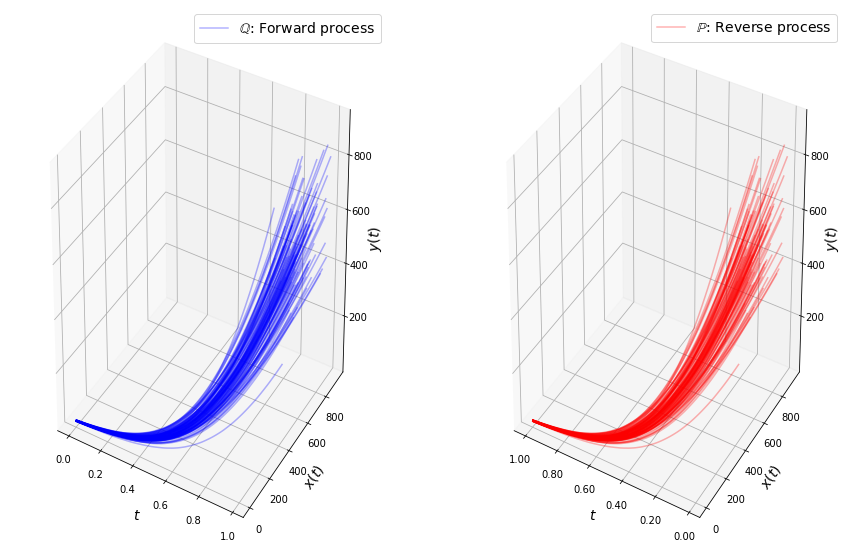

In [6]:
time = True

dim = 2 if time else 1

drift_q = lambda x: 5.0 * x[...,:-1]
dt = 1.0 / 100.0


# Estimating the backward drift of brownian motion
t, Q_2 = solve_sde_RK(alfa=drift_q, beta=1.0, X0=X1+5, dt=dt, N=int(1/dt))
plot_trajectories_both(Q_2, t, Q_2, t)

In [7]:
# initialize likelihood and model
def set_up_gp(Xs, Ys):
    n, out_dims = Ys.shape
    sigma = 1.0
    
    
    kern_list =  []
    gps = []
    Xs = Xs.detach().cpu().numpy()
    for i in range(out_dims):
        kern_list.append(
            GPy.kern.RBF(input_dim = 3, lengthscale=1.0, variance=1.0)
        )
                
        Yi = Ys[:,i][...,None].detach().cpu().numpy()
        gps.append( 
            GPy.models.GPRegression(Xs, Yi, kern_list[i])
        )


    return gps


In [8]:
def gp_drift_mean(X, m):
    n, out_dims = X.shape
    out_dims -= 1
    
    Xds = []
    means = []
    for i in range(out_dims):
        means.append(m[i].predict(X.detach().cpu().numpy())[0])
    
    mean = np.concatenate(means, axis=1)

    return torch.tensor(mean).double().cuda()


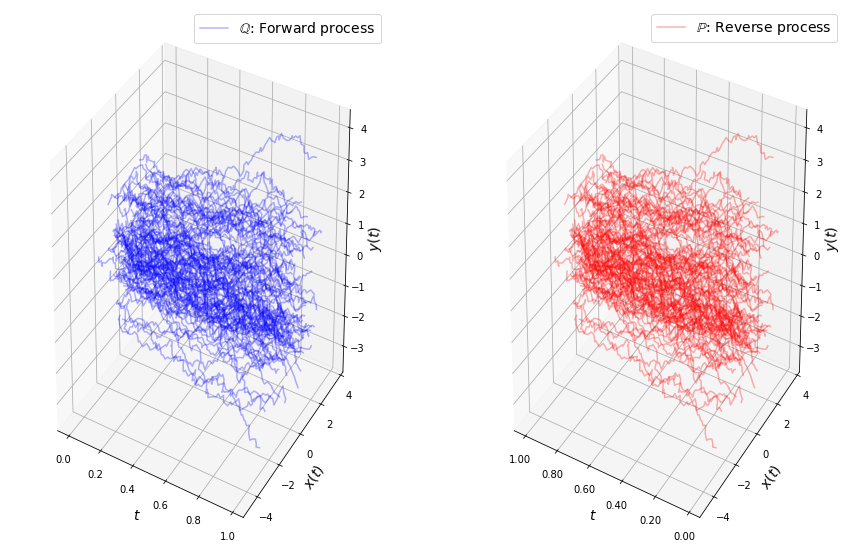

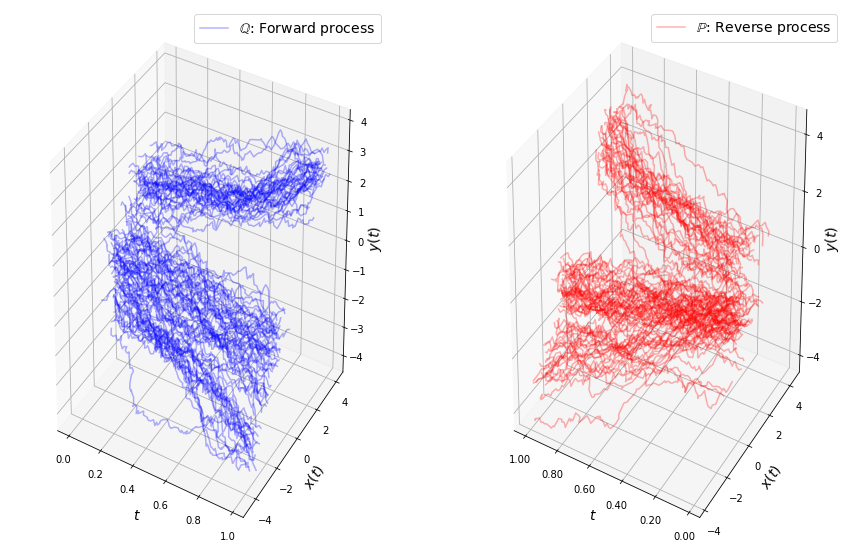

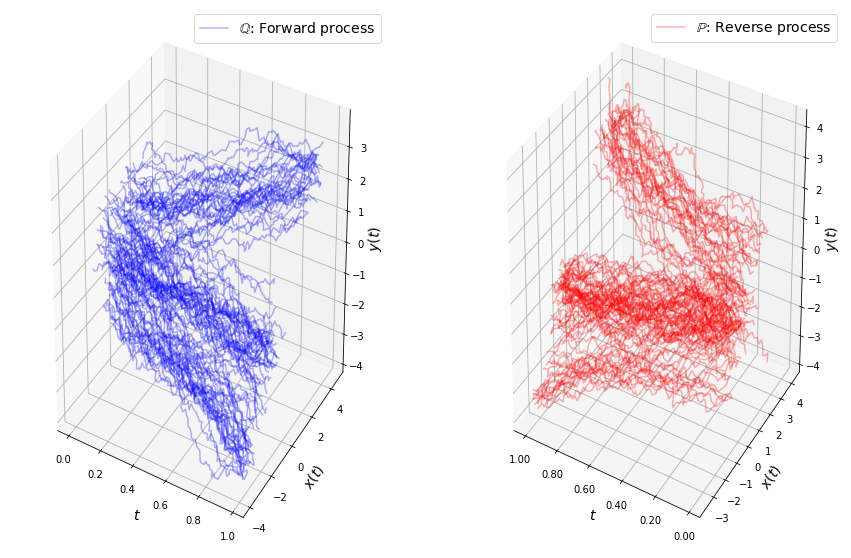

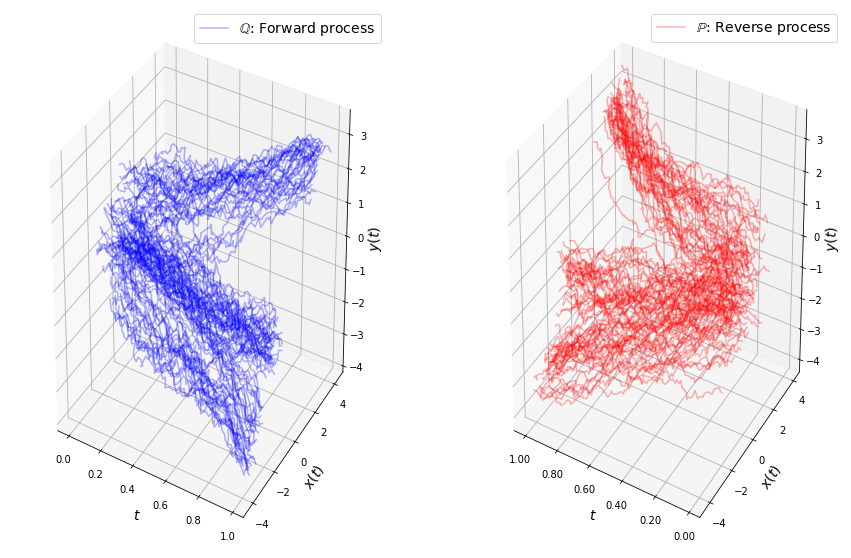

In [ ]:
time = True

dim = 2 if time else 1

drift_q = lambda x: 0
# N = 70
N = 70
dt = 1.0 / N

sigma = 1
p0_W_sigma  = 1
# Estimating the backward drift of brownian motion
t, Q_2 = solve_sde_RK(alfa=drift_q, beta=sigma, X0=X1, dt=dt, N=int(1/dt))

Xs2, Ys2 = get_drift_data(Q_2, dt)

m_p = set_up_gp(Xs2, Ys2)

drift_p = lambda x: gp_drift_mean(x, m_p)

plot_trajectories_both(Q_2, t, Q_2, t)

for i in range(200):
    
    # backward
    t, Q_1 = solve_sde_RK(alfa=drift_p, beta=sigma, X0=X2,dt=dt, N=int(1/dt))
    
    Xs, Ys = get_drift_data(Q_1, dt)
    
    m_q = set_up_gp(Xs, Ys)
    
    drift_q = lambda x: gp_drift_mean(x, m_q)
    
    
    T, M = solve_sde_RK(alfa=drift_q, beta=1, X0=Q_1[:,-1,:-1],dt=dt, N=int(1/dt))
#     plot_trajectories_(M, T)
    
    # forward
    t, Q_2 = solve_sde_RK(alfa=drift_q, beta=sigma, X0=X1,dt=dt, N=int(1/dt))
    
    Xs2, Ys2 = get_drift_data(Q_2, dt)
    
    m_p = set_up_gp(Xs2, Ys2)
    
    drift_p = lambda x: gp_drift_mean(x, m_p)
    
    
    T2, M2 = solve_sde_RK(alfa=drift_p, beta=sigma, X0=Q_2[:,-1,:-1],dt=dt, N=int(1/dt))

#     plot_trajectories_(M2,  T2)
    plot_trajectories_both(M, T, M2, T2)

In [64]:
# fig, axs = plt.subplots(1,2, sharey=False, figsize=(15, 8))
# axs[0].plot(c.loss_f[2:], color="blue", label="forward")
# axs[0].set_xlabel("Iteration")
# axs[0].set_ylabel("Loss")
# axs[0].legend()
# axs[1].plot(c.loss_b[2:], color="red", label="backward")
# axs[1].set_xlabel("Iteration")
# axs[1].set_ylabel("Loss")
# axs[1].legend()
# plt.savefig("_hard_relu_30_30_30__succesfl_bimodal_epochs.png")


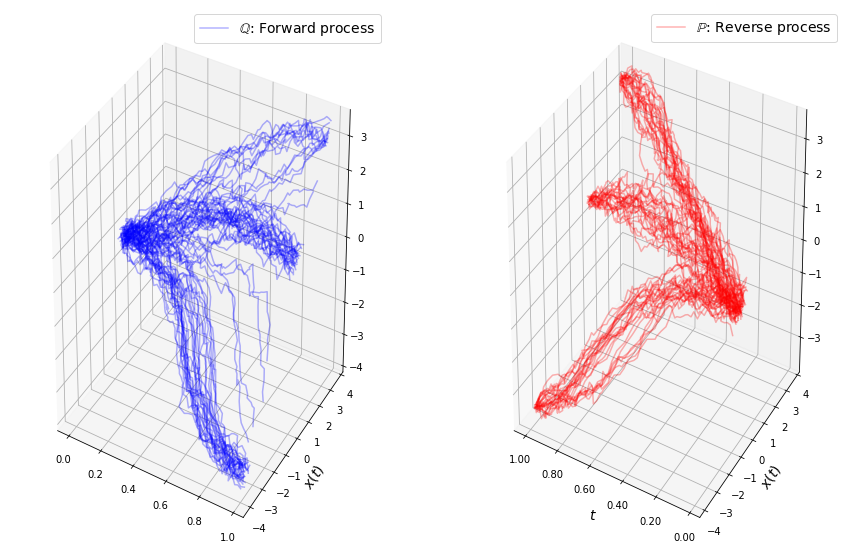

In [65]:
t, Xts = solve_sde_RK(alfa=drift_q, beta=sigma, X0=X1,dt=dt, N=int(1/dt))
t_, Xts_ = solve_sde_RK(alfa=drift_p, beta=sigma, X0=X2,dt=dt, N=int(1/dt))

plot_trajectories_both(Xts, t, Xts_, t_)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


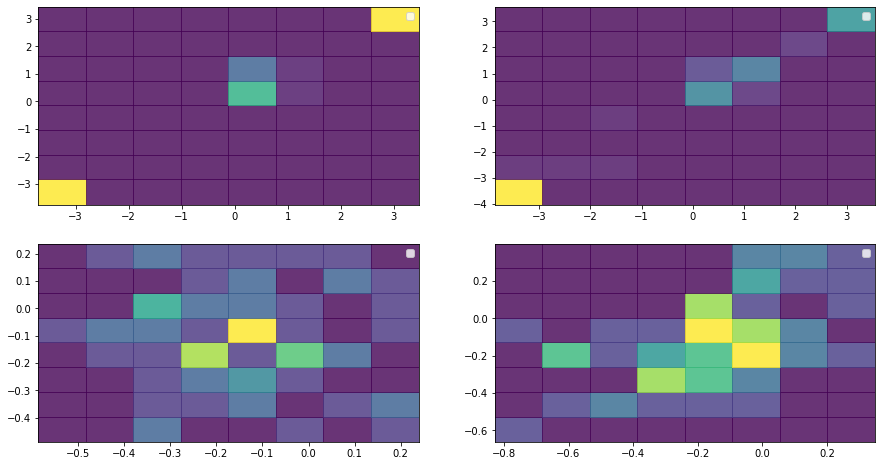

In [66]:
fig, axs = plt.subplots(2,2, figsize=(15, 8))


bins = 8

X1_ = ( X1.detach().cpu().numpy() )
Xts__ = ( Xts_[:,-1,:-1].detach().cpu().numpy())

axs[1,0].hist2d(X1_[:,0], X1_[:,1], alpha=0.8, bins=bins, label="target", density=True);
axs[1,1].hist2d(Xts__[:,0], Xts__[:,1], alpha=0.8, bins=bins, label="fitted", density=True);
axs[1,0].legend()
axs[1,1].legend()


X2_ = ( X2.detach().cpu().numpy())
Xtss = ( Xts[:,-1,:-1].detach().cpu().numpy())

axs[0,0].hist2d(X2_[:,0], X2_[:,1], alpha=0.8, bins=bins, label="target", density=True);
axs[0,1].hist2d(Xtss[:,0], Xtss[:,1], alpha=0.8, bins=bins, label="fitted", density=True);
axs[0,0].legend()
axs[0,1].legend()
# plt.savefig("hard_relu_20_20_20__succesfl_bimodal_boundaires.png")

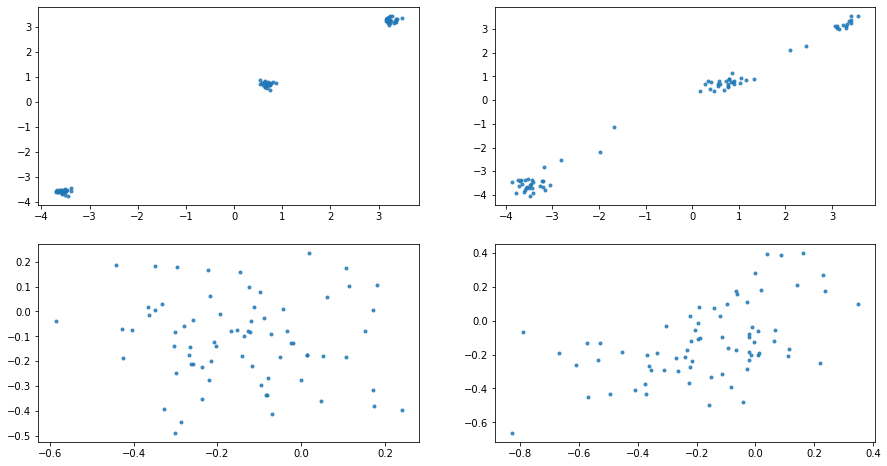

In [67]:
fig, axs = plt.subplots(2,2, figsize=(15, 8))


bins = 19

X1_ = ( X1.detach().cpu().numpy() )
Xts__ = ( Xts_[:,-1,:-1].detach().cpu().numpy())

axs[1,0].plot(X1_[:,0], X1_[:,1], ".", alpha=0.8, label="target");
axs[1,1].plot(Xts__[:,0], Xts__[:,1], ".", alpha=0.8, label="fitted");
# axs[1,0].legend()
# axs[1,1].legend()


X2_ = ( X2.detach().cpu().numpy())
Xtss = ( Xts[:,-1,:-1].detach().cpu().numpy())

axs[0,0].plot(X2_[:,0], X2_[:,1], ".", alpha=0.8, label="target");
axs[0,1].plot(Xtss[:,0], Xtss[:,1], ".", alpha=0.8, label="fitted");
# axs[0,0].legend()plot